In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# Loading the datasets
training_data = pd.read_csv('Training Data.csv')
test_data = pd.read_csv('Test Data.csv')

In [ ]:
# Dropping 'Id' column as it is not needed for model training
if 'Id' in training_data.columns:
    training_data.drop('Id', axis=1, inplace=True)
if 'Id' in test_data.columns:
    test_data.drop('Id', axis=1, inplace=True)

# Handling missing values - Filling numeric with median, categorical with mode
for column in training_data.columns:
    if training_data[column].dtype in ['int64', 'float64']:
        training_data[column].fillna(training_data[column].median(), inplace=True)
        test_data[column].fillna(test_data[column].median(), inplace=True)
    else:
        training_data[column].fillna(training_data[column].mode()[0], inplace=True)
        test_data[column].fillna(test_data[column].mode()[0], inplace=True)

# Mapping the values 'Married/Single' to 0/1
marital_status_mapping = {'single': 0, 'married': 1}
training_data['Married/Single'] = training_data['Married/Single'].map(marital_status_mapping)
test_data['Married/Single'] = test_data['Married/Single'].map(marital_status_mapping)


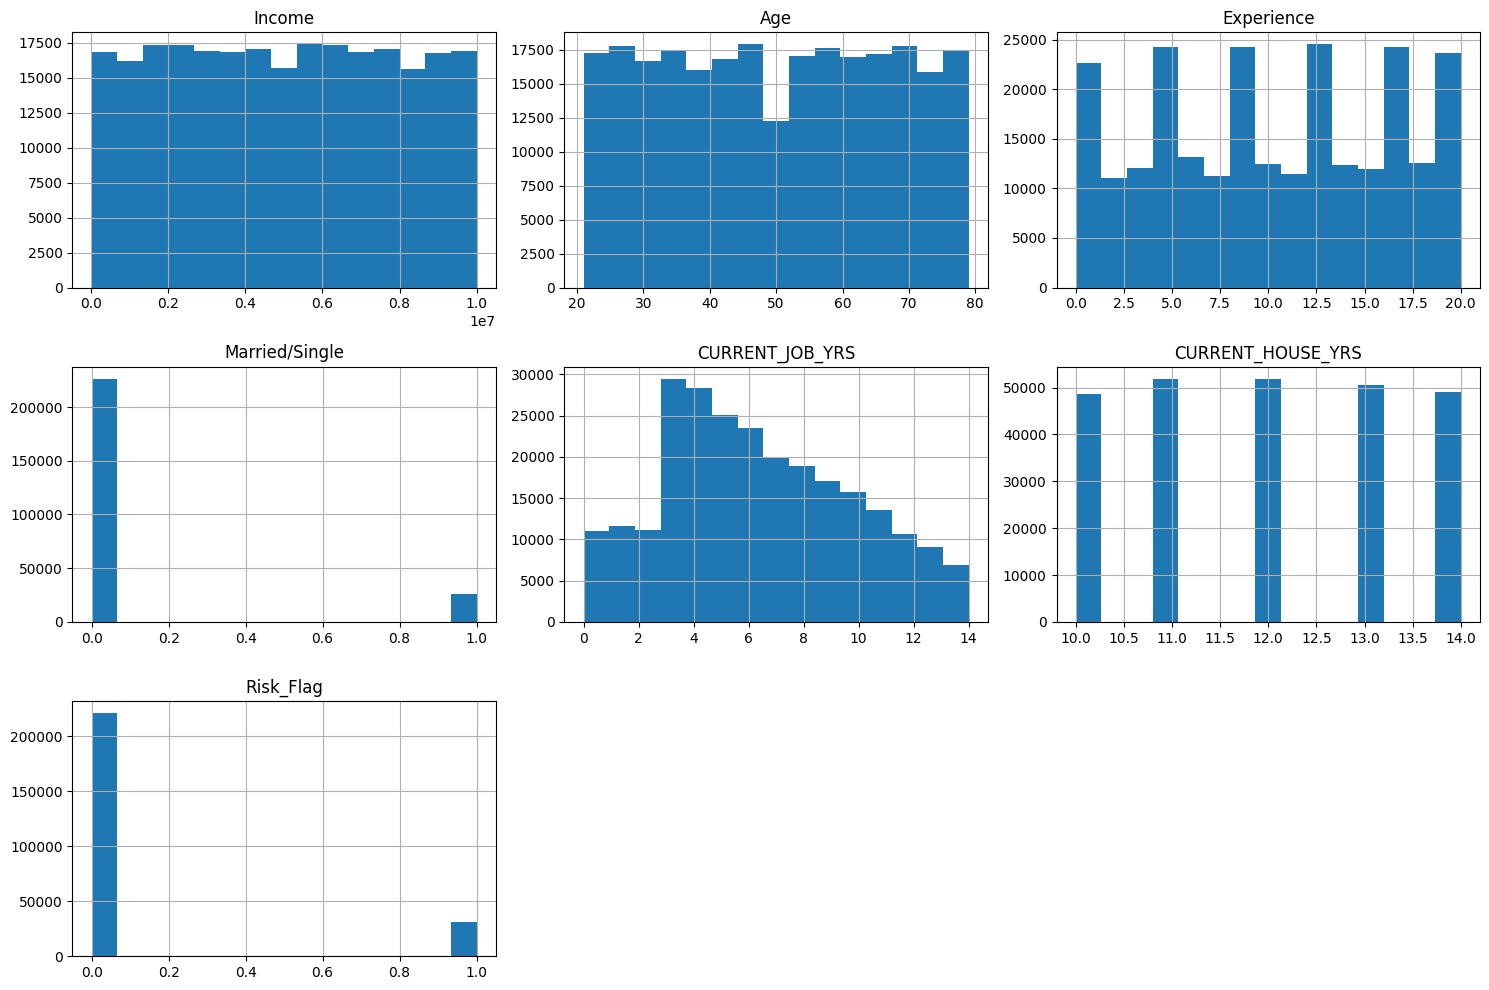

In [ ]:
#Performing Univariate Analysis
training_data.hist(figsize=(15, 10), bins=15)
plt.tight_layout()
plt.show()

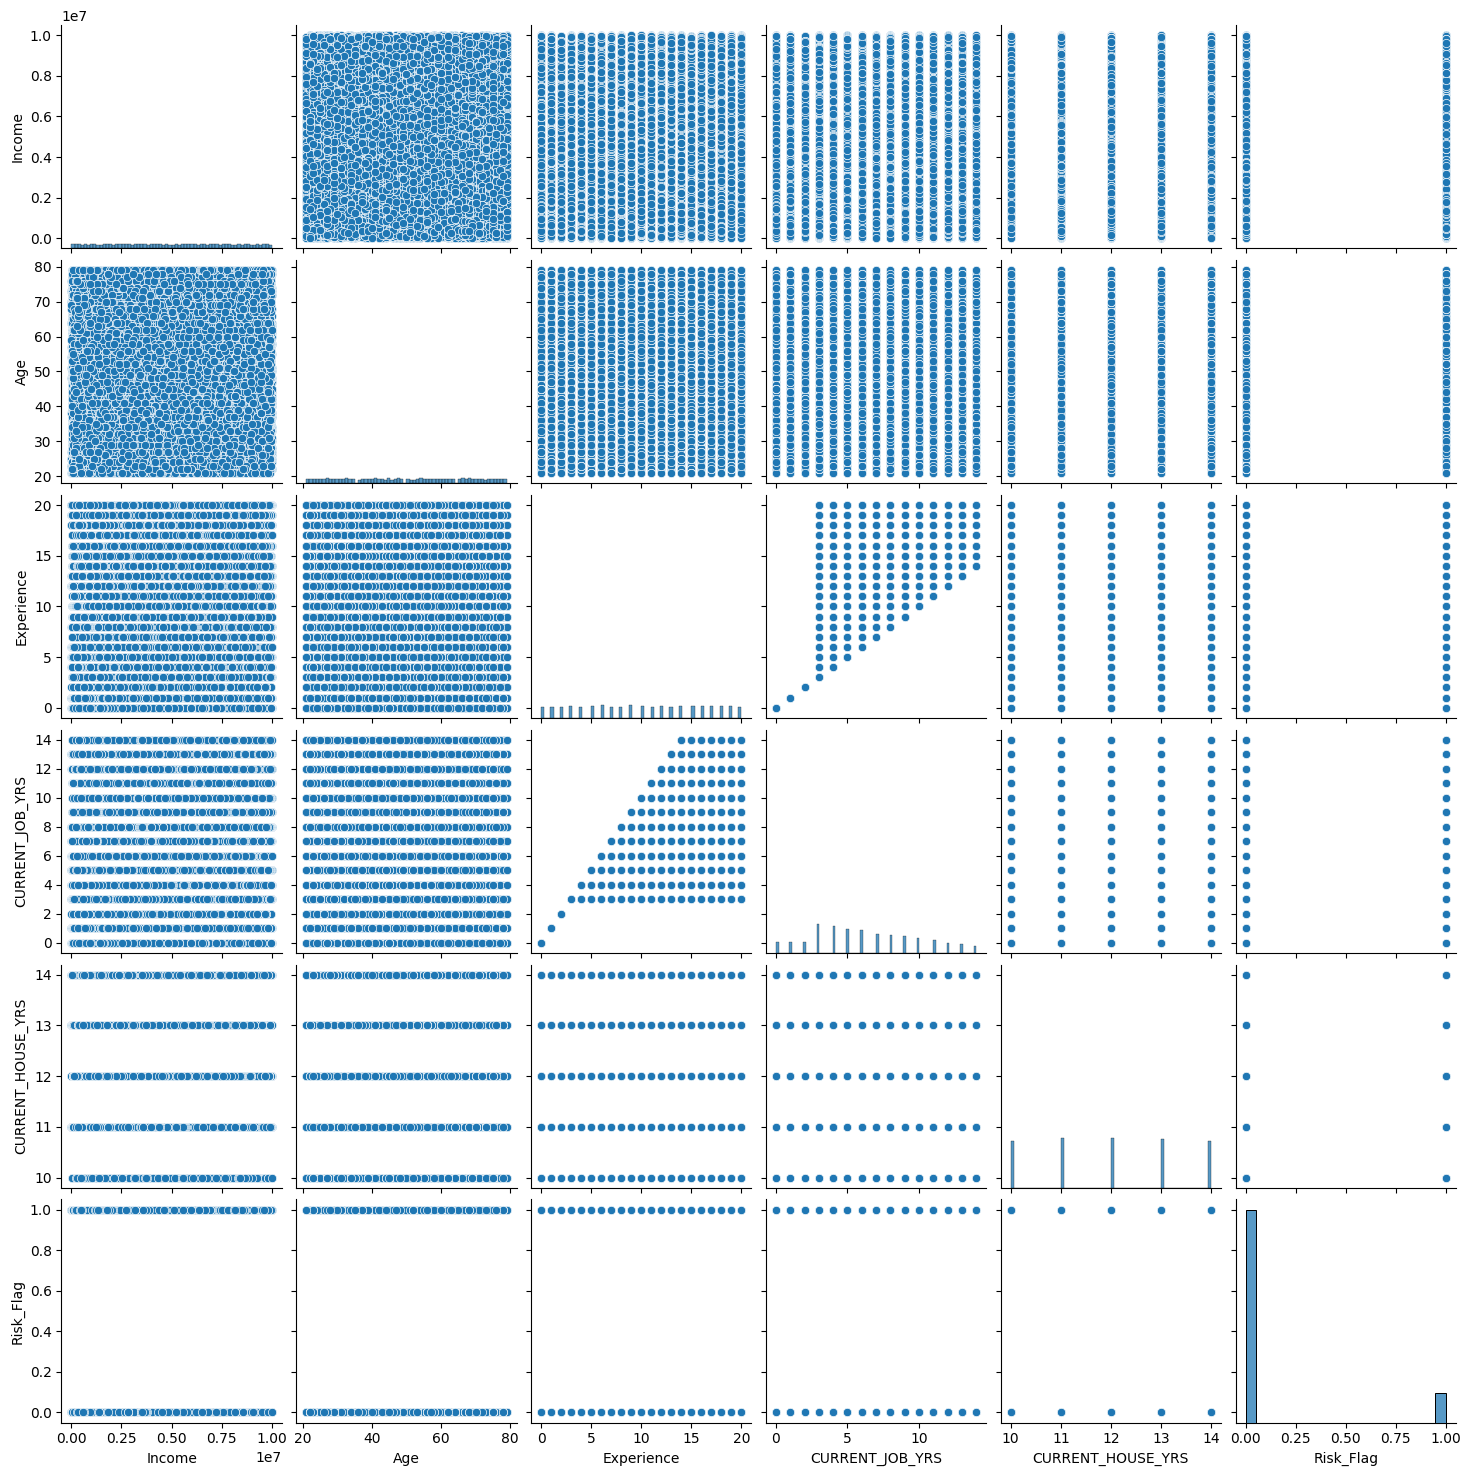

In [ ]:
# Performing Bivariate Analysis
sns.pairplot(training_data[['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag']])
plt.show()


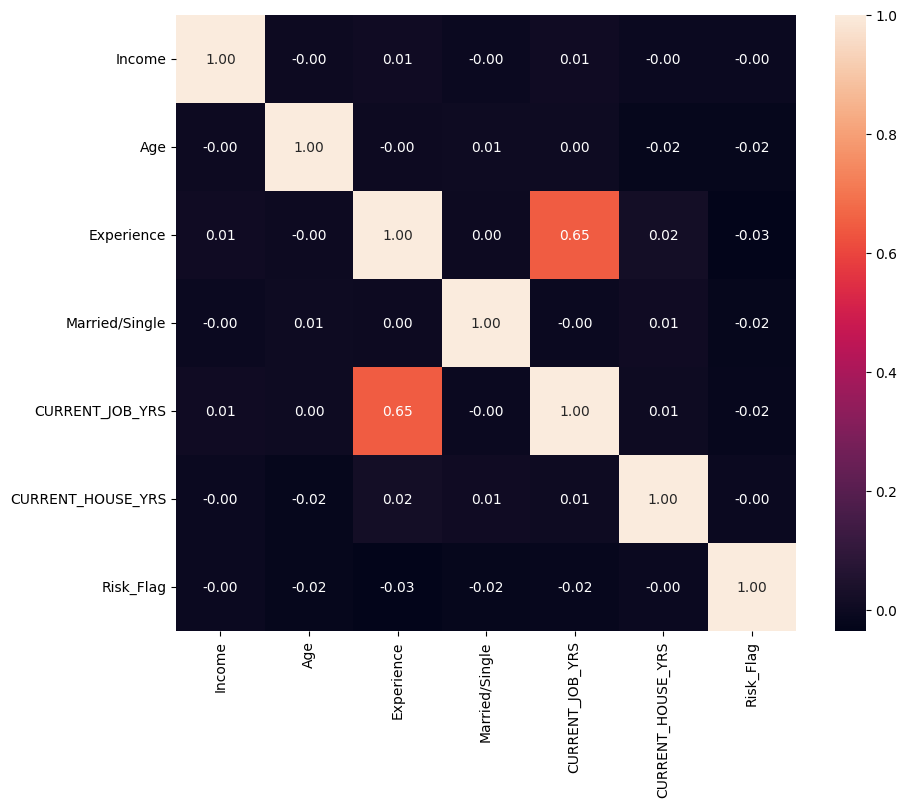

In [ ]:
#Performing Multivariate Analysis
plt.figure(figsize=(10, 8))
sns.heatmap(training_data.corr(), annot=True, fmt=".2f")
plt.show()



In [ ]:
# Encoding categorical features since they are not in numeric format
training_data_encoded = pd.get_dummies(training_data)
test_data_encoded = pd.get_dummies(test_data)

# Align the training and test data to ensure they have the same columns
# This will check if both have same column names or else it will produce errors
training_data_encoded, test_data_encoded = training_data_encoded.align(test_data_encoded, join='inner', axis=1)
# 'Risk_Flag' is the target variable -- Need to predict this column
X = training_data_encoded.drop('Risk_Flag', axis=1)
y = training_data_encoded['Risk_Flag']


In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

# Perform GridSearchCV for hyperparameter tuning
rf_grid_search = GridSearchCV(estimator=rf_clf, param_grid=rf_param_grid, cv=3, scoring='accuracy', error_score='raise')
rf_grid_search.fit(X_train, y_train)


GridSearchCV(cv=3, error_score='raise',
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20], 'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [ ]:
# Getting the best parameters and the best score
rf_best_params = rf_grid_search.best_params_
rf_best_score = rf_grid_search.best_score_

# Train the model with the best parameters to get best results
rf_best_clf = RandomForestClassifier(**rf_best_params, random_state=42,)
rf_best_clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=20, random_state=42)

In [ ]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
# Validate the Random Forest model
rf_val_predictions = rf_best_clf.predict(X_val)
rf_val_accuracy = accuracy_score(y_val, rf_val_predictions)

# Output the performance
print("Random Forest Best Parameters:", rf_best_params)
print("Random Forest Best CV Score:", rf_best_score)
print("Random Forest Validation Accuracy:", rf_val_accuracy)

Random Forest Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Best CV Score: 0.8777083333333334
Random Forest Validation Accuracy: 0.8764310231939842


In [ ]:
# Random forest accuracy of Test set
X1 = training_data_encoded.drop('Risk_Flag', axis=1)
y1 = training_data_encoded['Risk_Flag']

rf_val_predictions = rf_best_clf.predict(X1)
rf_val_accuracy = accuracy_score(y1, rf_val_predictions)
print("Random Forest Testing Accuracy:", rf_val_accuracy)

Random Forest Testing Accuracy: 0.8775282637767311


In [ ]:
# Function to clean the feature names
# Issues with column names
def clean_feature_names(df):
    clean_names = {}
    for col in df.columns:
        clean_name = col.strip().replace('[', '').replace(']', '').replace('<', '')
        clean_names[col] = clean_name
    return df.rename(columns=clean_names)

# Clean the feature names for both training and test data -- Doing it due to column name issues/mismatches
X_train = clean_feature_names(X_train)
X_val = clean_feature_names(X_val)
test_data_encoded = clean_feature_names(test_data_encoded)

from xgboost import XGBClassifier
# setting up the XGBoost model and GridSearch
xgb_clf = XGBClassifier(random_state=42)

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1],
    'subsample': [1],
    'colsample_bytree': [1],
}


In [ ]:
# Perform GridSearchCV for hyperparameter tuning
xgb_grid_search = GridSearchCV(estimator=xgb_clf, param_grid=xgb_param_grid, cv=2, scoring='accuracy', error_score='raise')
xgb_grid_search.fit(X_train, y_train)


GridSearchCV(cv=2, error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [1], 'learning_rate': [0.1],
                         'max_depth': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [1]},
             scoring='accuracy')

In [ ]:

# Get the best parameters and the best score for XGBoost
xgb_best_params = xgb_grid_search.best_params_
xgb_best_score = xgb_grid_search.best_score_

# Train the XGBoost model with the best parameters
xgb_best_clf = XGBClassifier(**xgb_best_params, random_state=42)
xgb_best_clf.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Validate the XGBoost model
xgb_val_predictions = xgb_best_clf.predict(X_val)
xgb_val_accuracy = accuracy_score(y_val, xgb_val_predictions)

# Output the XGBoost performance
print("XGBoost Best Parameters:", xgb_best_params)
print("XGBoost Best CV Score:", xgb_best_score)
print("XGBoost Validation Accuracy:", xgb_val_accuracy)

XGBoost Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}
XGBoost Best CV Score: 0.8780803571428571
XGBoost Validation Accuracy: 0.8773437034979464


In [ ]:
# XgBoost accuracy of Test set
tce =  clean_feature_names(test_data_encoded)
X1 = tce.drop('Risk_Flag', axis=1)
y1 = tce['Risk_Flag']

xgb_val_predictions = xgb_best_clf.predict(X1)
xgb_val_accuracy = accuracy_score(y1, xgb_val_predictions)
print("XGBoost Testing Accuracy:", xgb_val_accuracy)

XGBoost Testing Accuracy: 0.8701785714285715
